# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig0870s2"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 400

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '/*.jpg')
    if aktsubdir == "NaN":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        x_data.append(test_image)
        y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1132, 32, 20, 3)
(1132, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 32)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/400
283/283 [==============================] - 4s 7ms/step - loss: 2.1317 - accuracy: 0.3654: 1s - loss: 2.2 - ETA: 
Epoch 2/400
283/283 [==============================] - 2s 8ms/step - loss: 1.4747 - accuracy: 0.5282
Epoch 3/400
283/283 [==============================] - 2s 8ms/step - loss: 1.0329 - accuracy: 0.6978
Epoch 4/400
283/283 [==============================] - 2s 7ms/step - loss: 0.7898 - accuracy: 0.7527
Epoch 5/400
283/283 [==============================] - 2s 7ms/step - loss: 0.6313 - accuracy: 0.8080
Epoch 6/400
283/283 [==============================] - 2s 9ms/step - loss: 0.6211 - accuracy: 0.8185
Epoch 7/400
283/283 [==============================] - 2s 8ms/step - loss: 0.5579 - accuracy: 0.8184
Epoch 8/400
283/283 [==============================] - 3s 9ms/step - loss: 0.5474 - accuracy: 0.8259
Epoch 9/400
283/283 [==============================] - 2s 8ms/step - loss: 0.4118 - accuracy: 0.8792
Epoch 10/400
283/283 [==============================] - 2s 8ms/step

283/283 [==============================] - 3s 10ms/step - loss: 0.0826 - accuracy: 0.9737
Epoch 80/400
283/283 [==============================] - 3s 10ms/step - loss: 0.1136 - accuracy: 0.9717 0s - loss: 0.1140 - accuracy
Epoch 81/400
283/283 [==============================] - 3s 10ms/step - loss: 0.0984 - accuracy: 0.9747
Epoch 82/400
283/283 [==============================] - 3s 10ms/step - loss: 0.0637 - accuracy: 0.9792
Epoch 83/400
283/283 [==============================] - 3s 9ms/step - loss: 0.0756 - accuracy: 0.9807
Epoch 84/400
283/283 [==============================] - 3s 9ms/step - loss: 0.0759 - accuracy: 0.9766
Epoch 85/400
283/283 [==============================] - 3s 9ms/step - loss: 0.0785 - accuracy: 0.9758
Epoch 86/400
283/283 [==============================] - 3s 9ms/step - loss: 0.0950 - accuracy: 0.9717
Epoch 87/400
283/283 [==============================] - 3s 10ms/step - loss: 0.1437 - accuracy: 0.9628
Epoch 88/400
283/283 [==============================] - 3s 9m

283/283 [==============================] - 3s 9ms/step - loss: 0.0438 - accuracy: 0.9925
Epoch 159/400
283/283 [==============================] - 3s 9ms/step - loss: 0.0588 - accuracy: 0.9855
Epoch 160/400
283/283 [==============================] - 3s 9ms/step - loss: 0.0778 - accuracy: 0.9773
Epoch 161/400
283/283 [==============================] - 3s 9ms/step - loss: 0.0407 - accuracy: 0.9840
Epoch 162/400
283/283 [==============================] - 3s 9ms/step - loss: 0.0598 - accuracy: 0.9923
Epoch 163/400
283/283 [==============================] - 3s 9ms/step - loss: 0.0489 - accuracy: 0.9853: 0s - loss: 0.0468 - accura
Epoch 164/400
283/283 [==============================] - 3s 9ms/step - loss: 0.0845 - accuracy: 0.9671
Epoch 165/400
283/283 [==============================] - 3s 10ms/step - loss: 0.0433 - accuracy: 0.9846
Epoch 166/400
283/283 [==============================] - 3s 9ms/step - loss: 0.0414 - accuracy: 0.9849
Epoch 167/400
283/283 [==============================] - 3

283/283 [==============================] - 3s 9ms/step - loss: 0.0354 - accuracy: 0.9903
Epoch 237/400
283/283 [==============================] - 3s 9ms/step - loss: 0.0524 - accuracy: 0.9814
Epoch 238/400
283/283 [==============================] - 2s 8ms/step - loss: 0.0476 - accuracy: 0.9880
Epoch 239/400
283/283 [==============================] - 3s 9ms/step - loss: 0.1176 - accuracy: 0.9846
Epoch 240/400
283/283 [==============================] - 2s 9ms/step - loss: 0.0517 - accuracy: 0.9906
Epoch 241/400
283/283 [==============================] - 2s 9ms/step - loss: 0.0316 - accuracy: 0.9924
Epoch 242/400
283/283 [==============================] - 3s 9ms/step - loss: 0.0718 - accuracy: 0.9829
Epoch 243/400
283/283 [==============================] - 2s 9ms/step - loss: 0.0290 - accuracy: 0.9850
Epoch 244/400
283/283 [==============================] - 2s 9ms/step - loss: 0.0308 - accuracy: 0.9908
Epoch 245/400
283/283 [==============================] - 3s 9ms/step - loss: 0.0259 - a

Epoch 315/400
283/283 [==============================] - 2s 8ms/step - loss: 0.0129 - accuracy: 0.9940
Epoch 316/400
283/283 [==============================] - 3s 9ms/step - loss: 0.0450 - accuracy: 0.9880
Epoch 317/400
283/283 [==============================] - 2s 8ms/step - loss: 0.0745 - accuracy: 0.9795
Epoch 318/400
283/283 [==============================] - 2s 8ms/step - loss: 0.0544 - accuracy: 0.9867
Epoch 319/400
283/283 [==============================] - 3s 9ms/step - loss: 0.0949 - accuracy: 0.9860
Epoch 320/400
283/283 [==============================] - 2s 8ms/step - loss: 0.0436 - accuracy: 0.9885
Epoch 321/400
283/283 [==============================] - 2s 8ms/step - loss: 0.0399 - accuracy: 0.9940
Epoch 322/400
283/283 [==============================] - 3s 9ms/step - loss: 0.0235 - accuracy: 0.9935
Epoch 323/400
283/283 [==============================] - 2s 8ms/step - loss: 0.0594 - accuracy: 0.9864
Epoch 324/400
283/283 [==============================] - 2s 8ms/step - lo

283/283 [==============================] - 2s 8ms/step - loss: 0.0126 - accuracy: 0.9963
Epoch 394/400
283/283 [==============================] - 2s 8ms/step - loss: 0.0501 - accuracy: 0.9828
Epoch 395/400
283/283 [==============================] - 2s 7ms/step - loss: 0.0133 - accuracy: 0.9940
Epoch 396/400
283/283 [==============================] - 2s 8ms/step - loss: 0.0472 - accuracy: 0.9888
Epoch 397/400
283/283 [==============================] - 2s 8ms/step - loss: 0.0627 - accuracy: 0.9873
Epoch 398/400
283/283 [==============================] - 2s 8ms/step - loss: 0.0545 - accuracy: 0.9865
Epoch 399/400
283/283 [==============================] - 2s 8ms/step - loss: 0.0475 - accuracy: 0.9873
Epoch 400/400
283/283 [==============================] - 2s 7ms/step - loss: 0.0204 - accuracy: 0.9924


### Learing result
 
* Visualization of the training and validation results

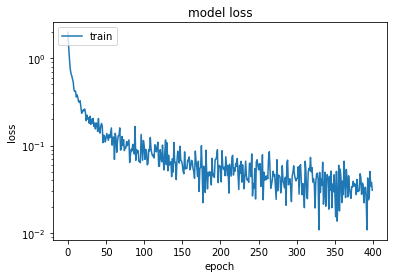

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

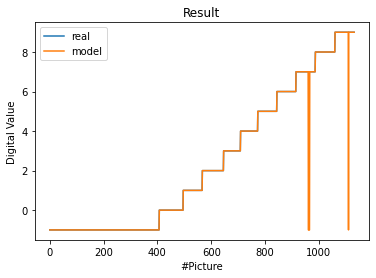

In [6]:
Input_dir='ziffer_sortiert_resize'
subdir = ["NaN", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
res = []

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    if aktsubdir == "NaN":
        zw1 = -1
    else:
        zw1 = int(aktsubdir)
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = -1
        zw2 = classes
        zw3 = zw2 - zw1
        res.append(np.array([zw1, zw2, zw3]))

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpl231jt9t\assets


356604

In [8]:
FileName = TFliteNamingAndVersion + "q"

import tensorflow as tf

def representative_dataset():
    for _ in range(500):
      data = np.random.rand(1, 32, 20, 3) * 255
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName + ".tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpvnpzd9q9\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpvnpzd9q9\assets


98512

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


In [9]:
Input_dir='ziffer_sortiert_resize'
only_deviation = True

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    expected_class = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = "NaN"
        if only_deviation == True:
            if str(classes) != str(expected_class):
                print(aktfile + " " + aktsubdir +  " " + str(classes))
        else:
            print(aktfile + " " + aktsubdir +  " " + str(classes))


ziffer_sortiert_resize/7\D6_2020-08-14_15-13-16.jpg 7 NaN
ziffer_sortiert_resize/7\D6_2020-08-19_21-15-56.jpg 7 NaN
ziffer_sortiert_resize/7\D7_2020-08-19_22-45-38.jpg 7 NaN
ziffer_sortiert_resize/7\D7_2020-08-20_15-23-28.jpg 7 NaN
ziffer_sortiert_resize/9\D8_2020-08-20_11-32-19.jpg 9 NaN


Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.